# 2. Data preparation

---

### Setup

In [9]:
import sys
sys.path.insert(1, '../../utils')

import pandas as pd

original: pd.DataFrame = pd.read_csv('../qsar_oral_toxicity_after_profiling.csv', sep=';')

## 2.0. Data preparation

---

### Missing Values Imputation

---

In our dataset there are no missing values and therefore this step is not appliable.

### Outliers Imputation
---

In [2]:
#TODO

### Scaling

---

Since all variables are binary (0 or 1) they are already scaled. Therefore, no scaling is needed.

### Splits

---

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import ds_functions as ds

original_copy = original.copy(deep = True)

target = 'exp'
positive = True
negative = False
values = {'Original': [len(original_copy[original_copy[target] == positive]), len(original_copy[original_copy[target] == negative])]}

y: np.ndarray = original_copy.pop(target).values
X: np.ndarray = original_copy.values
labels: np.ndarray = pd.unique(y)

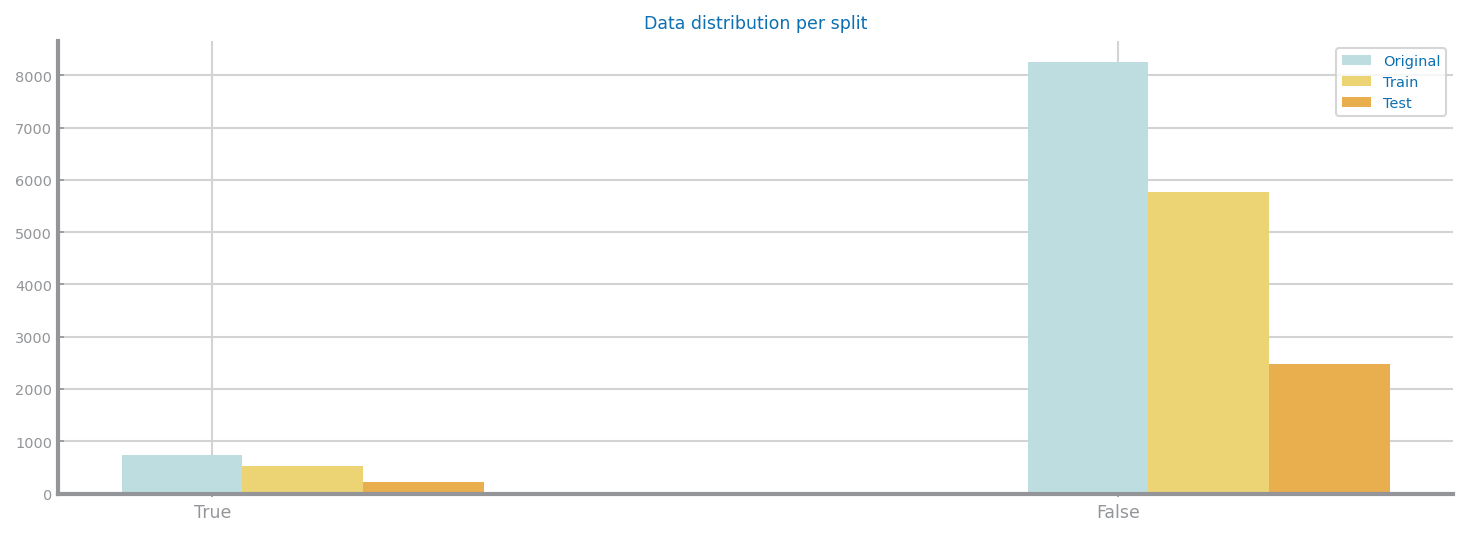

In [11]:
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==negative))), len(np.delete(trnY, np.argwhere(trnY==positive)))]
values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==negative))), len(np.delete(tstY, np.argwhere(tstY==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per split', showXTickLabels = True)
plt.show()

### Data balancing

---

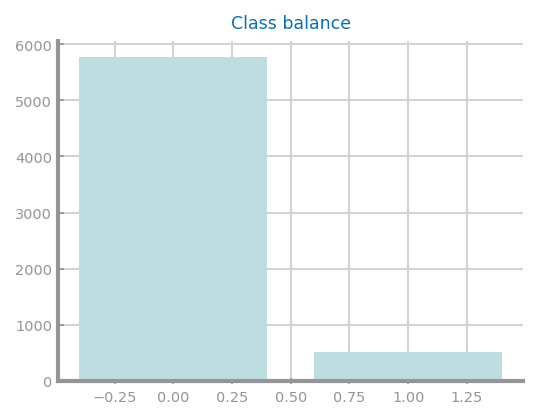

Minority class: 519
Majority class: 5774
Proportion: 0.09 : 1


In [28]:
import matplotlib.pyplot as plt

split = {}

columnsX = list(original.columns)
columnsX.remove(target)

split['X_train'] = pd.DataFrame(data=trnX, columns=columnsX)
split['y_train'] = pd.DataFrame(data=trnY, columns=[target])
split['X_test'] = pd.DataFrame(data=tstX, columns=columnsX)
split['y_test'] = pd.DataFrame(data=tstY, columns=[target])

trainData = pd.concat([split['X_train'], split['y_train']], axis = 1)
testData = pd.concat([split['X_test'], split['y_test']], axis = 1)

target_count = trainData['exp'].value_counts()
plt.figure()
plt.title('Class balance')
plt.bar(target_count.index, target_count.values)
plt.show()

min_class = target_count.idxmin()
ind_min_class = target_count.index.get_loc(min_class)

print('Minority class:', target_count[ind_min_class])
print('Majority class:', target_count[1-ind_min_class])
print('Proportion:', round(target_count[ind_min_class] / target_count[1-ind_min_class], 3), ': 1')

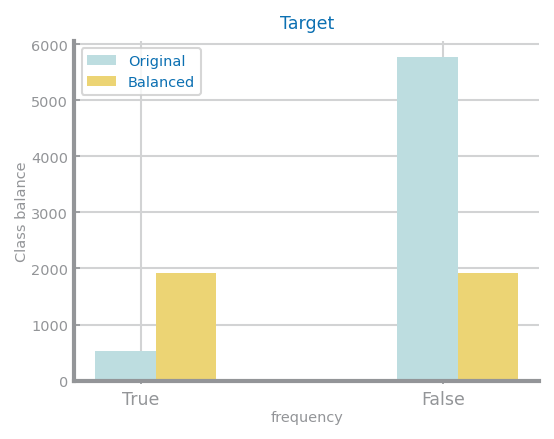

In [29]:
import ds_functions as ds

df_class_min = trainData[trainData['exp'] == min_class]
df_class_max = trainData[trainData['exp'] != min_class]

values = {'Original': [target_count.values[ind_min_class], target_count.values[1-ind_min_class]]}

FINAL_SIZE = len(df_class_max) // 3

# Oversampling
df_class_min_sample = df_class_min.sample(FINAL_SIZE, replace=True)
# Undersampling
df_class_max_sample = df_class_max.sample(FINAL_SIZE)

values['Balanced'] = [len(df_class_min_sample), len(df_class_max_sample)]

fig = plt.figure()
ds.multiple_bar_chart([target_count.index[ind_min_class], target_count.index[1-ind_min_class]], values,
                      title='Target', xlabel='frequency', ylabel='Class balance', showXTickLabels=True)
plt.show()

balanced = pd.concat((df_class_min_sample, df_class_max_sample))

In [14]:
# Finally, export prepared data to csv
trainData.to_csv('data/prepared/data.csv', sep=';', index=False)
balanced.to_csv('data/prepared_b/data.csv', sep=';', index=False)
testData.to_csv('data/prepared_test/data.csv', sep=';', index=False)

### Feature Selection

---

#### Unsupervised Selection

By definition, unsupervised selection only aims for eliminating redundancies among the
variables, getting the smallest set possible.

In [8]:
import seaborn as sns
import numpy as np

data_dict = {'balanced': balanced, 'train': trainData}
data_dict_unsupervised = {'balanced': None, 'train': None}

for key in data_dict:
    df = data_dict[key]
    
    copy = df.copy(deep=True)
    copy = copy.drop('exp', axis = 1)
    corrs = copy.corr()

    removed = []

    for x in corrs:
        for y in corrs:
            if x == y:
                break
            corr = corrs[x][y]
            if abs(corr) >= 0.8 and x not in removed and y not in removed:
                copy = copy.drop(x, axis=1)
                removed.append(x)
                break

    copy['exp'] = df['exp']
    
    data_dict_unsupervised[key] = copy.copy(deep=True)

KeyboardInterrupt: 

#### Supervised Selection

In the context of supervised selection, the goal is to identify the most relevant variables
in relation to the target variable, and so we need criteria able to relate each variable
with the target one.

In [ ]:
importances = {'balanced': None, 'train': None}

for key in data_dict_unsupervised:
    importances[key] = data_dict_unsupervised[key].drop('exp', axis=1).apply(lambda x: x.corr(copy.exp))
    print('%s\n\n' % key, importances[key], '\n\n\n')

In [ ]:
new_data_dict_unsupervised = {'balanced': None, 'train': None}
for key in data_dict_unsupervised:
    new_data_dict_unsupervised[key] = data_dict_unsupervised[key].copy(deep=True)

    for i in range(0, len(importances[key])):
        if np.abs(importances[key][i]) < 0.10:
            new_data_dict_unsupervised[key] = new_data_dict_unsupervised[key].drop(importances[key].index[i], axis=1)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import pandas as pd

newest_copy = {'balanced': None, 'train': None}
for key in new_data_dict_unsupervised:
    newest_copy[key] = new_data_dict_unsupervised[key].copy(deep=True)

    X = pd.get_dummies(newest_copy[key].drop('exp', axis=1))
    y = pd.get_dummies(newest_copy[key]['exp'])


    #feature selection using chi2
    bestfeatures = SelectKBest(score_func=chi2, k='all')
    fit = bestfeatures.fit(X, y)
    #create df for scores
    dfscores = pd.DataFrame(fit.scores_)
    #create df for column names
    dfcolumns = pd.DataFrame(X.columns)

    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    #naming the dataframe columns
    featureScores.columns = ['Selected_columns','Score_chi2']

    for i in range(0, len(featureScores)):
        if featureScores['Score_chi2'][i] <= 50:
            newest_copy[key] = newest_copy[key].drop(featureScores['Selected_columns'][i], axis=1)

In [ ]:
newest_copy['balanced'].to_csv('data/prepared_b_s/data.csv', sep=';', index=False)
newest_copy['train'].to_csv('data/prepared_s/data.csv', sep=';', index=False)

### Summary

---

***Are all variables in the same scale? If not, how does scaling impact the results?***

Yes, they are all binary and, therefore, all in the same scale.

***Is the dataset unbalanced? If yes, what is the best balancing technique to apply?***

Yes, the dataset is way unbalanced. To balance it we used two techniques: oversampling for the minority class (positive) and undersampling for the majority class (negative).

### Feature Extraction

---

#### Principal component analysis


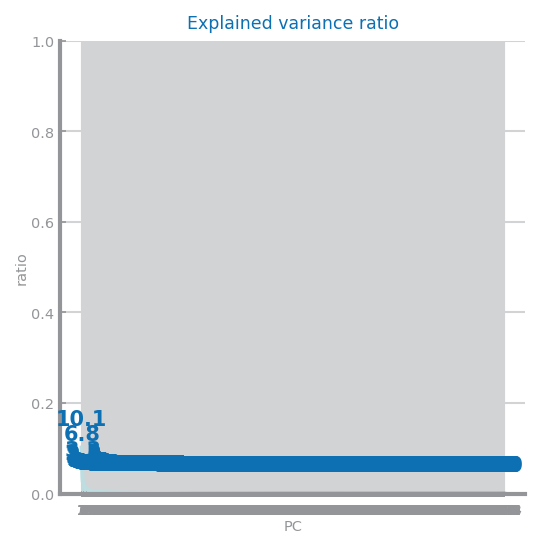

           PC1       PC2       PC3       PC4       PC5       PC6
0     4.808010  2.006587 -0.173545 -2.078130  1.766830  1.892689
1     3.514226  1.718016  0.399577 -4.047948  0.266210  2.056631
2     3.213805  9.201667  1.834021 -4.119710  0.194135 -0.432161
3     5.369068  5.283680 -2.774836 -0.115066 -2.422774 -0.481665
4     6.038490  3.408478  2.025548 -2.018993 -0.878070 -0.199438
...        ...       ...       ...       ...       ...       ...
6288  5.501096  1.770709  0.067240 -0.628588  0.161180 -0.201358
6289  1.210087  5.269299  4.068869 -1.639475 -1.625891  0.810560
6290  5.938133  1.194529  0.004561 -0.515743  1.600212 -0.336471
6291  0.261921  2.456032  3.099120 -0.751758 -1.227049 -0.944724
6292  0.297284  4.278933  1.811186 -1.081603 -2.303024  0.929744

[6293 rows x 6 columns]


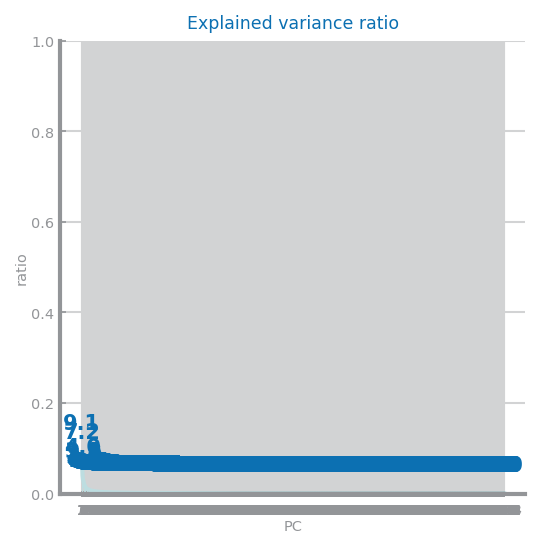

           PC1       PC2       PC3       PC4       PC5       PC6
0     2.996791  2.535527 -0.337001  0.480172  1.145810 -3.849484
1     3.583396  3.664784 -0.069600  1.618093  2.274214 -3.210395
2     4.418342 -1.287829  4.506886  0.496376  2.667446 -2.555646
3     5.008753  1.495768  0.812933  0.546018  1.788408  0.828588
4    -0.315932  7.562695  3.875881  0.508019  0.706247 -0.227177
...        ...       ...       ...       ...       ...       ...
3843 -0.409925  1.774064 -0.147277  0.939180  0.516478  0.024345
3844  6.077704  1.933634  0.436698 -0.515354  1.040750 -0.706703
3845  3.031630  2.628486  1.248531  2.655069 -0.725121 -2.640746
3846 -0.025832  2.424121  0.912849  0.057459  0.029408 -0.158652
3847 -0.082071  3.821648  0.637095 -0.901875  1.557906 -0.929867

[3848 rows x 6 columns]


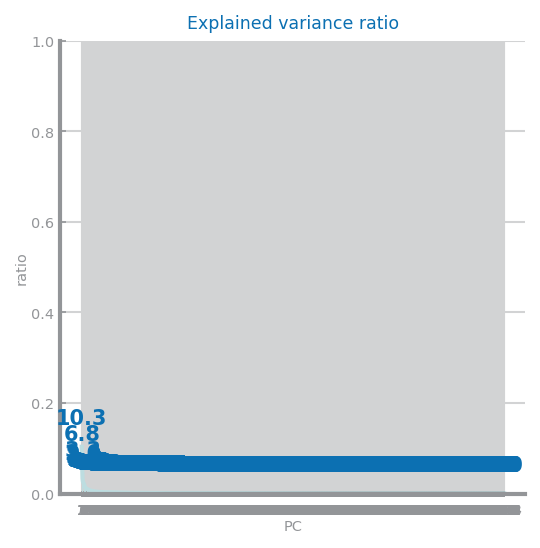

           PC1       PC2       PC3       PC4       PC5       PC6
0     3.321350  1.003632 -1.759772 -2.052806  0.070034 -0.176386
1     6.095231  3.629000  1.533501 -2.721759  0.390601  1.671711
2     4.127447  2.008140  1.024079 -3.673729 -1.796804 -0.329120
3     2.166045  2.517629 -2.523050 -1.746503 -0.084085 -0.122743
4     3.751490  1.043169 -1.150371 -2.479965 -0.077471 -0.581798
...        ...       ...       ...       ...       ...       ...
2693  0.134271  3.985212  0.455013 -0.938574 -0.967997  2.434514
2694  5.218653  4.403461 -1.938127 -0.026929 -2.064669  0.759727
2695  4.648439  3.407444  1.254125 -2.720914  0.784989  1.434251
2696  6.722105  2.698247  1.652014 -1.825775 -1.920644 -1.034475
2697  6.252832  3.526817 -0.334859 -0.150715 -1.251951  3.117081

[2698 rows x 6 columns]


In [30]:
old_datasets = (trainData, balanced, testData)
new_datasets = ()

for dataset in old_datasets:
    target_data = dataset.pop('exp').reset_index().drop(columns='index')
    data = dataset

    from sklearn.decomposition import PCA

    mean = (data.mean(axis=0)).tolist()
    centered_data = data - mean
    cov_mtx = centered_data.cov()
    eigvals, eigvecs = np.linalg.eig(cov_mtx)

    pca = PCA()
    pca.fit(centered_data)
    PC = pca.components_
    var = pca.explained_variance_

    # PLOT EXPLAINED VARIANCE RATIO
    fig = plt.figure(figsize=(4, 4))
    plt.title('Explained variance ratio')
    plt.xlabel('PC')
    plt.ylabel('ratio')
    x_values = [str(i) for i in range(1, len(pca.components_) + 1)]
    bwidth = 0.5
    ax = plt.gca()
    ax.set_xticklabels(x_values)
    ax.set_ylim(0.0, 1.0)
    ax.bar(x_values, pca.explained_variance_ratio_, width=bwidth)
    ax.plot(pca.explained_variance_ratio_)
    for i, v in enumerate(pca.explained_variance_ratio_):
        ax.text(i, v+0.05, f'{v*100:.1f}', ha='center', fontweight='bold')
    plt.show()

    transf = pca.transform(data)
    data = pd.DataFrame(transf[:,:6], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
    print(data)
    data = data.join(target_data, how='right')
    
    new_datasets += (data,)

In [31]:
new_datasets[0].to_csv('data/prepared_fe/data.csv', sep=';', index=False)
new_datasets[1].to_csv('data/prepared_b_fe/data.csv', sep=';', index=False)
new_datasets[2].to_csv('data/prepared_test_fe/data.csv', sep=';', index=False)

           PC1       PC2       PC3       PC4       PC5       PC6    exp
0     2.996791  2.535527 -0.337001  0.480172  1.145810 -3.849484   True
1     3.583396  3.664784 -0.069600  1.618093  2.274214 -3.210395   True
2     4.418342 -1.287829  4.506886  0.496376  2.667446 -2.555646   True
3     5.008753  1.495768  0.812933  0.546018  1.788408  0.828588   True
4    -0.315932  7.562695  3.875881  0.508019  0.706247 -0.227177   True
...        ...       ...       ...       ...       ...       ...    ...
3843 -0.409925  1.774064 -0.147277  0.939180  0.516478  0.024345  False
3844  6.077704  1.933634  0.436698 -0.515354  1.040750 -0.706703  False
3845  3.031630  2.628486  1.248531  2.655069 -0.725121 -2.640746  False
3846 -0.025832  2.424121  0.912849  0.057459  0.029408 -0.158652  False
3847 -0.082071  3.821648  0.637095 -0.901875  1.557906 -0.929867  False

[3848 rows x 7 columns]
